# Steps of the Data Analysis of Astro

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

Reading and printing the Time Series (Observation of 10 seconds)

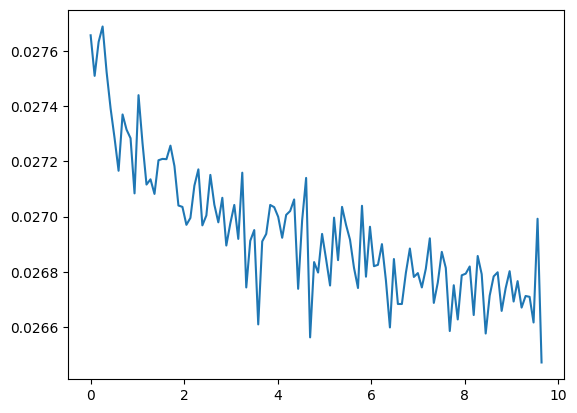

In [86]:
timeSeries = pd.read_csv('time_series.csv', names = ('Relative Time','Relative Power'))
plt.plot(timeSeries['Relative Time'],timeSeries['Relative Power'])

In [74]:
N = sum(1 for column in timeSeries['Relative Power']) 

In [89]:
RelativePower = fft(timeSeries, axis=0)
Frequency = fftfreq(N, 1/10)

ValueError: x and y must have same first dimension, but have shapes (1140,) and (114, 2)

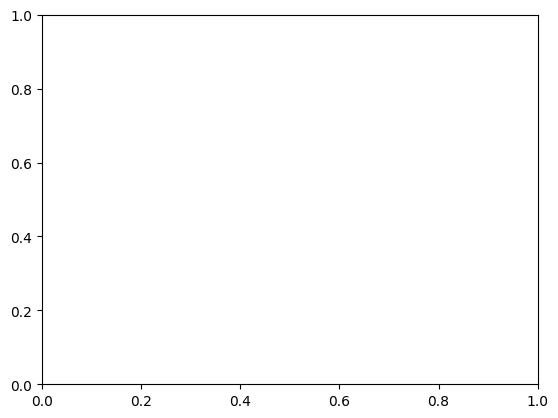

In [91]:
plt.plot(Frequency, RelativePower)